## Transformer

TensorFlowのチュートリアルを参考に、transformerモデルを理解する。
https://www.tensorflow.org/tutorials/text/transformer
- Self-Attention
- スケール済み内積アテンション
- マルチヘッド・アテンション
- 位置エンコーディング
- マスキング

## インポート

In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
#!pip install tensorflow-datasets
import tensorflow_datasets as tfds

## データセットの準備

In [10]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
    
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]
Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]


AttributeError: __enter__

In [3]:
# trainサンプルの表示
for i in train_examples:
    print(i)
    break

(<tf.Tensor: shape=(), dtype=string, numpy=b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'>, <tf.Tensor: shape=(), dtype=string, numpy=b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'>)


### トークナイザー

In [4]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [5]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [6]:
for ts in tokenized_string:
    print('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [7]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_LENGTH = 40

In [8]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(lang1.numpy()) + [tokenizer_pt.vocab_size+1]
    
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(lang2.numpy()) + [tokenizer_en.vocab_size+1]
    
    return lang1, lang2

In [9]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    
    result_pt.set_shape([None])
    result_en.set_shape([None])
    
    return result_pt, result_en

In [10]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    
    return tf.logical_and(tf.size(x) <= max_length,tf.size(y) <= max_length)

In [11]:
train_preprocessed = (train_examples
                      .map(tf_encode)
                      .filter(filter_max_length)
                      # 読み取り時のスピードアップのため、データセットをメモリ上にキャッシュする
                      .cache()
                      .shuffle(BUFFER_SIZE))

val_preprocessed = (val_examples
                    .map(tf_encode)
                    .filter(filter_max_length))

In [12]:
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
                 .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset = (val_preprocessed
               .padded_batch(BATCH_SIZE,  padded_shapes=([None], [None])))

In [13]:
# サンプリング
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

## 位置エンコーディング

In [14]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2))/np.float32(d_model))
    
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    # 配列中の偶数インデックスにはsinを適用; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # 配列中の奇数インデックスにはcosを適用; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 512, 512)


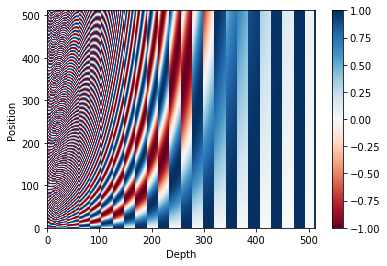

In [15]:
pos_encoding = positional_encoding(512, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## マスキング
シーケンスのバッチ中のパディングされた全てのトークンをマスクします。  
これにより、モデルがパディングを確実に入力として扱わないようにします。  
マスクは、パディング値0の存在を示します。つまり、0の場所で1を出力し、それ以外の場所では0を出力します。

In [16]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # アテンション・ロジットにパディングを追加するため
    # さらに次元を追加する
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [17]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [18]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    
    return mask  # (seq_len, seq_len)

In [19]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## スケール済み内積アテンション

In [20]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    アテンションの重みの計算
    q, k, vは最初の次元が一致していること
    k, vは最後から2番めの次元が一致していること
    マスクは型（パディングかルックアヘッドか）によって異なるshapeを持つが、加算の際にブロードキャスト可能であること
    
    引数：
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: (..., seq_len_q, seq_len_k) にブロードキャスト可能なshapeを持つ浮動小数点テンソル。既定値はNone
    
    戻り値：
    出力、アテンションの重み
    """
    
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    
    # matmul_qkをスケール
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # マスクをスケール済みテンソルに加算
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
        
    # softmax は最後の軸(seq_len_k)について
    # 合計が1となるように正規化
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    
    return output, attention_weights

def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [21]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [ 0,10, 0],
                      [ 0, 0,10],
                      [ 0, 0,10]],
                     dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]],
                     dtype=tf.float32)  # (4, 2)

# この`query`は2番目の`key`に割り付けられているので
# 2番めの`value`が返される
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [22]:
# このクエリは（3番目と 4番目の）繰り返しキーに割り付けられるので
# 関連した全ての値が平均される
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [23]:
# このクエリは最初と2番めのキーに等しく割り付けられるので
# それらの値が平均される
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


## マルチヘッド・アテンション
- 線形レイヤーとマルチヘッドの分割
- スケール済み内積アテンション
- マルチヘッドの結合
- 最終線形レイヤー

In [24]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        
        self.d_model = d_model
        self.num_heads = num_heads
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """
        最後の次元を(num_heads, depth)に分割。
        結果をshapeが(batch_size, num_heads, seq_len, depth)となるようにリシェイプする。
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape = (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = \
        scaled_dot_product_attention(q, k, v, mask)
        
        # scaled_attention.shape = (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) 
        
        # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)
        
        return output, attention_weights

In [25]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)

y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
print(out.shape, attn.shape)

(1, 60, 512) (1, 8, 60, 60)


## ポイントワイズ・フィードフォワード・ネットワーク

In [26]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [27]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## エンコードレイヤー

In [28]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        # Multi-Head-Attention
        attn_output, _ = self.mha(x, x, x, mask)
        # Dropout layer
        attn_output = self.dropout1(attn_output, training=training)
        # Layer Normalization(ResidualNet)
        out1 = self.layernorm1(x + attn_output)  
        # Point-wise FFN
        ffn_output = self.ffn(out1)
        
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        
        return out2

In [29]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = \
sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)

print(sample_encoder_layer_output.shape)

(64, 43, 512)


## デコーダーレイヤー

In [30]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape = (batch_size, input_seq_len, d_model)
        
        attn1, attn_weights_block1 = \
        self.mha1(x, x, x, look_ahead_mask)
        
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = \
        self.mha2(enc_output, enc_output, out1, padding_mask)
        
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2

In [32]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = \
sample_decoder_layer(tf.random.uniform((64, 50, 512)),
                     sample_encoder_layer_output, 
                     False, None, None)

print(sample_decoder_layer_output.shape)

(64, 50, 512)


## エンコーダー
- 入力の埋め込み
- 位置エンコーディング
- N層のエンコーダレイヤー

In [34]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,num_layers, d_model, num_heads, dff,
                 input_vocab_size,maximum_position_encoding, rate=0.1):
        
        super(Encoder, self).__init__()
        
        self.num_layers = num_layers
        self.d_model = d_model
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        
        self.pos_encoding = \
        positional_encoding(maximum_position_encoding, self.d_model)
        
        self.enc_layers = \
        [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        # 埋め込みと位置エンコーディングを合算する
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
            
        return x

In [35]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, dff=2048,
                         input_vocab_size=8500, maximum_position_encoding=10000)

temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)

(64, 62, 512)


## デコーダー
- 出力埋め込み
- 位置エンコーディング
- N層のデコーダレイヤー

In [36]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 target_vocab_size,maximum_position_encoding, rate=0.1):
        
        super(Decoder, self).__init__()
        
        self.num_layers = num_layers
        self.d_model = d_model
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.dec_layers = \
        [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        
        attention_weights = {}
        
        x = self.embedding(x) 
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = \
            self.dec_layers[i](x, enc_output, training,look_ahead_mask, padding_mask)
            
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        
        return x, attention_weights

In [37]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, dff=2048,
                         target_vocab_size=8000, maximum_position_encoding=5000)

temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

print(output.shape, attn['decoder_layer2_block2'].shape)

(64, 26, 512) (64, 8, 26, 62)


## Transformer

In [38]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)
        
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, 
             look_ahead_mask, dec_padding_mask):
        
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        dec_output, attention_weights = \
        self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights

In [43]:
sample_transformer = Transformer(num_layers=2, d_model=512, num_heads=8, dff=2048, 
                                 input_vocab_size=8500, target_vocab_size=8000, 
                                 pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

print(fn_out.shape)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Cast: Dst tensor is not initialized. [Op:Cast] name: Cast/

In [41]:
# ハイパーパラメータ
num_layers = 4 # 6
d_model = 128 # 512
dff = 512 # 2048
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## カスタムオプティマイザー

In [42]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [44]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

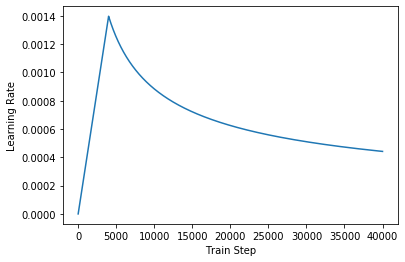

In [45]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 損失関数と評価関数

In [46]:
loss_object = \
tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [47]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [48]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

train_accuracy = \
tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

## モデルの訓練とチェックポイントの設定

In [49]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Cast: Dst tensor is not initialized. [Op:Cast] name: Cast/

In [50]:
def create_masks(inp, tar):
    # Encoderパディング・マスク
    enc_padding_mask = create_padding_mask(inp)
    
    # デコーダーの 2つ目のアテンション・ブロックで使用
    # このパディング・マスクはエンコーダーの出力をマスクするのに使用
    dec_padding_mask = create_padding_mask(inp)
    
    # デコーダーの 1つ目のアテンション・ブロックで使用
    # デコーダーが受け取った入力のパディングと将来のトークンをマスクするのに使用
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# チェックポイントが存在したなら、最後のチェックポイントを復元
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')